In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor


import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append('../data')
    sys.path.append('../src')
from plot_features_importance import plot_features_importance

SEED =1   

import warnings
warnings.filterwarnings('ignore') 


### Read data

In [2]:
df = pd.read_csv("../data/bikes.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1488 entries, 0 to 1487
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   hr                      1488 non-null   int64  
 1   holiday                 1488 non-null   int64  
 2   workingday              1488 non-null   int64  
 3   temp                    1488 non-null   float64
 4   hum                     1488 non-null   float64
 5   windspeed               1488 non-null   float64
 6   cnt                     1488 non-null   int64  
 7   instant                 1488 non-null   int64  
 8   mnth                    1488 non-null   int64  
 9   yr                      1488 non-null   int64  
 10  Clear to partly cloudy  1488 non-null   int64  
 11  Light Precipitation     1488 non-null   int64  
 12  Misty                   1488 non-null   int64  
dtypes: float64(3), int64(10)
memory usage: 151.3 KB


In [3]:
df.head()

,hr,holiday,workingday,temp,hum,windspeed,cnt,instant,mnth,yr,Clear to partly cloudy,Light Precipitation,Misty
0,0,0,0,0.76,0.66,0.0000,149,13004,7,1,1,0,0
1,1,0,0,0.74,0.70,0.1343,93,13005,7,1,1,0,0
2,2,0,0,0.72,0.74,0.0896,90,13006,7,1,1,0,0
3,3,0,0,0.72,0.84,0.1343,33,13007,7,1,1,0,0
4,4,0,0,0.70,0.79,0.1940,4,13008,7,1,1,0,0


### Split data into training and testing sets

In [4]:
X = df.drop("cnt", axis=1)
y = df["cnt"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=SEED)

### Random Forest

In [5]:
rf = RandomForestRegressor(random_state=SEED)
print(rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}


### GridSearch

In [6]:
params_rf = {
    "n_estimators": [100, 350, 500],
    "max_features": ["log2", "auto", "sqrt"],
    "min_samples_leaf": [2, 10, 30],
}

# Instantiate grid_rf
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring="neg_mean_squared_error",
                       cv=3,
                       verbose=1,
                       n_jobs=-1)

grid_rf.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_features': ['log2', 'auto', 'sqrt'],
                         'min_samples_leaf': [2, 10, 30],
                         'n_estimators': [100, 350, 500]},
             scoring='neg_mean_squared_error', verbose=1)

In [7]:
best_hyperparams = grid_rf.best_params_
print("Best hyperparameters:\n", best_hyperparams)

Best hyperparameters:
 {'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 500}


In [8]:
# Extract the best estimator
best_model = grid_rf.best_estimator_

# Predict test set labels
y_pred =  best_model.predict(X_test)

# Compute rmse_test
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print rmse_test 
print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 

Test RMSE of best model: 77.042


### Plot features importance

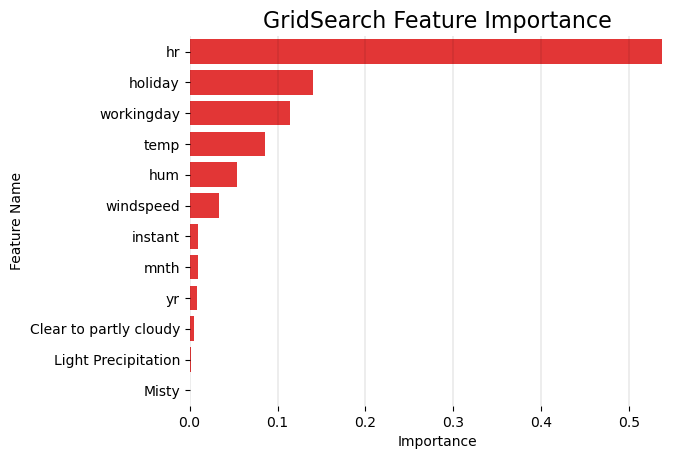

In [9]:
plot_features_importance(best_model.feature_importances_, X_train.columns.to_list(), "GridSearch Feature Importance")

### Gradient Boosting Regressor

In [10]:
# Instantiate gb
gb = GradientBoostingRegressor(n_estimators=200,
                               max_depth=4,
                               random_state=2)


# Fit gb to the training set
gb.fit(X_train, y_train)

# Predict test set labels
y_pred=gb.predict(X_test)


# Compute MSE
mse_test = MSE(y_test, y_pred)

# Compute RMSE
rmse_test = mse_test**(1/2)

# Print RMSE
print('Test set RMSE of gb: {:.3f}'.format(rmse_test))

Test set RMSE of gb: 43.113


### Plot features importance for Gradient Boosting

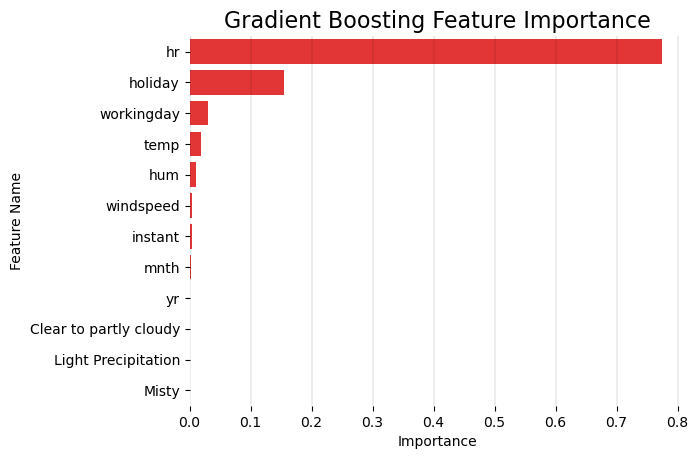

In [11]:
plot_features_importance(gb.feature_importances_, X_train.columns, "Gradient Boosting Feature Importance")

### Stochastic Gradient Boosting (SGB) 

In [12]:
# Instantiate sgbr
sgbr = GradientBoostingRegressor(max_depth=4, 
            subsample=0.9,
            max_features=0.75,
            n_estimators=200,
            random_state=2)


# Fit sgbr to the training set
sgbr.fit(X_train, y_train)

# Predict test set labels
y_pred = y_pred=sgbr.predict(X_test)


# Compute test set MSE
mse_test = MSE(y_test, y_pred)

# Compute test set RMSE
rmse_test = mse_test**(1/2)

# Print rmse_test
print('Test set RMSE of sgbr: {:.3f}'.format(rmse_test))

Test set RMSE of sgbr: 45.143


### Plot features importance for Stochastic Gradient Boosting

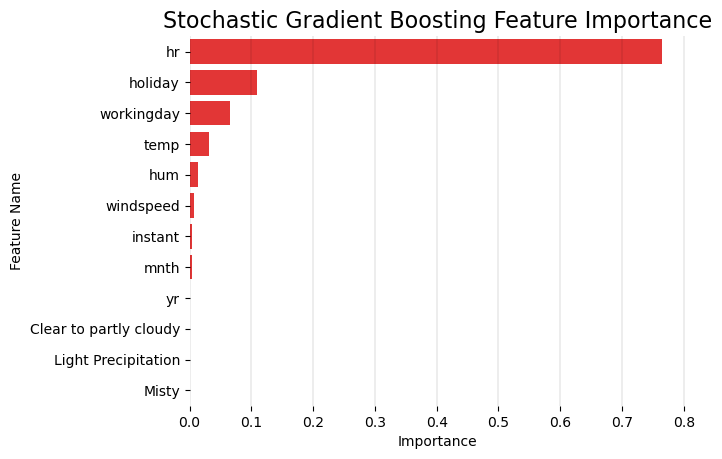

In [13]:
plot_features_importance(sgbr.feature_importances_, X_train.columns, "Stochastic Gradient Boosting Feature Importance")